# Phase 3: Microservice Identification (Grouping by Similar Services)

In [1]:
version = "v_team" # All options: v_imen, v_team
system = "pos" # All options: jforum, cargotracker, petclinic, pos
model_type = "codebert" # All options: ft_codebert, word2vec, albert, codebert, roberta, bert
best_community_detection_algorithm = 'Louvain' # All options: Louvain, EdMot, Infomap, LabelPropagation, FastGreedy, GirvanNewman

In [2]:
import pandas as pd
import numpy as np
from utils import save_microservices_to_txt, save_microservices_to_csv, calculate_microservices_clustering_results
import networkx as nx
import skfuzzy as fuzz
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from graphs import remove_zero_weight_edges, print_graph, construct_dissimilarity_matrix
from optimization import detect_elbow
from cluster_analysis import assign_clusters_based_on_comparative_ratios, merge_overlapping_clusters, identify_standalone_services
from normalization import normalize_data, normalize_memberships
from distances import compute_static_distances_for_service_pairs, compute_semantic_distances_for_service_pairs

## 1.1 Create service graph

In [3]:
# Global variable for filename
filename = f"generated_data/graph/service/{version}_{system}_service_graph.csv"

# Load the data from CSV files
communities_df = pd.read_csv(f"generated_data/phase2_service_clustering/{version}_{system}_{best_community_detection_algorithm}_communities.csv")
class_graph_df = pd.read_csv(f"generated_data/graph/class/{version}_{system}_class_graph.csv")
embeddings_df = pd.read_csv(f"generated_data/embedding/{version}_{system}_{model_type}_embeddings.csv")

# Extract class names and their embeddings from the embeddings DataFrame
class_names = embeddings_df.iloc[:, 0].str.split(';', expand=True)[0]
embeddings = embeddings_df.iloc[:, 1:].values
class_embeddings_dict = dict(zip(class_names, embeddings))

In [4]:
# Compute static and semantic distances between service pairs
static_distances = compute_static_distances_for_service_pairs(class_graph_df, communities_df)
semantic_distances = compute_semantic_distances_for_service_pairs(class_embeddings_dict, communities_df)

# Normalize the distances between 0 and 1
normalized_static_distances = normalize_data(static_distances)
normalized_semantic_distances = normalize_data(semantic_distances)

# Create the service graph DataFrame
service_graph_data = [
    [s1, s2, normalized_static_distances.get((s1, s2), 0), normalized_semantic_distances.get((s1, s2), 0)]
    for s1, s2 in static_distances.keys()
]
service_graph_df = pd.DataFrame(service_graph_data, columns=['service1', 'service2', 'static_distance', 'semantic_distance'])

# Save the service graph DataFrame to a CSV file
service_graph_df.to_csv(filename, index=False)

## 1.2 Cluster services

In [5]:
def compute_edge_weight(semantic, static, alpha=0.5):
    """
    Compute the edge weight based on semantic and static similarity.

    Parameters:
        semantic (float): The semantic similarity value between two services.
        static (float): The static similarity value between two services.
        alpha (float): The weight given to the static similarity.

    Returns:
        float: The computed edge weight.
    """
    if not (0 <= semantic <= 1) or not (0 <= static <= 1):
        raise ValueError("Both 'semantic' and 'static' values should be between 0 and 1.")
    
    beta = 1 - alpha
    return alpha * static + beta * semantic

In [6]:
service_graph_df = pd.read_csv(filename)

services_graph = nx.DiGraph([
    (row['service1'], row['service2'], {"weight": compute_edge_weight(row['semantic_distance'], row['static_distance'], alpha=1.0)}) # adjust alpha here
    for _, row in service_graph_df.iterrows()
])

remove_zero_weight_edges(services_graph)
print_graph(services_graph)
nodes_list = list(services_graph.nodes)

# Construct the dissimilarity matrix
dissimilarity_matrix = construct_dissimilarity_matrix(services_graph)

Application Service 1 -> Entity Service 1: 0.108108108108108
Application Service 1 -> Entity Service 2: 0.108108108108108
Application Service 1 -> Entity Service 3: 1.0
Application Service 1 -> Entity Service 7: 0.054054054054054
Application Service 2 -> Entity Service 2: 0.7297297297297296
Application Service 3 -> Entity Service 5: 0.972972972972973
Application Service 4 -> Entity Service 1: 0.6486486486486486
Application Service 5 -> Application Service 1: 0.5135135135135136
Application Service 5 -> Entity Service 10: 0.1351351351351351
Application Service 5 -> Entity Service 3: 0.3513513513513513
Application Service 5 -> Entity Service 5: 0.081081081081081
Application Service 5 -> Entity Service 6: 0.108108108108108
Application Service 5 -> Entity Service 7: 0.081081081081081
Application Service 5 -> Entity Service 9: 0.5945945945945947
Application Service 6 -> Entity Service 6: 0.081081081081081
Application Service 6 -> Entity Service 8: 0.810810810810811
Application Service 7 -> E

### 1.2.1 Fuzzy C-means from Scikit

In [7]:
# Constants
FUZZINESS = 2
ERROR_THRESHOLD = 0.005
MAX_ITERATIONS = 1000
CLUSTER_RANGE = range(2, 100)

def determine_optimal_clusters(data):
    """Determines the optimal number of clusters using the Elbow method."""
    fpc_values = []
    for c_value in CLUSTER_RANGE:
        _, _, _, _, _, _, fpc = fuzz.cmeans(
            data.T, 
            c=c_value, 
            m=FUZZINESS, 
            error=ERROR_THRESHOLD, 
            maxiter=MAX_ITERATIONS
        )
        fpc_values.append(fpc)

    plt.figure()
    plt.plot(CLUSTER_RANGE, fpc_values)
    plt.title('Fuzzy Partition Coefficient (FPC) for different cluster numbers')
    plt.xlabel('Number of clusters')
    plt.ylabel('FPC')
    plt.grid(True)
    plt.show()

    return detect_elbow(fpc_values)

def fuzzy_cmeans_clustering(data, node_labels, optimal_clusters):
    """
    Clusters the data using Fuzzy C-Means, returning only significant memberships.
    
    Parameters:
        data: 2D array of shape (features, samples), the input data.
        node_labels: List of labels corresponding to the samples.
        optimal_clusters: The number of clusters to form as well as the number of centroids to generate.
        membership_threshold: Threshold for membership values to determine significant cluster membership.
        
    Returns:
        dict: A dictionary with node labels as keys and lists of (cluster, membership) tuples as values.
    """
    cntr, u, _, _, _, _, _ = fuzz.cmeans(
        data.T,
        c=optimal_clusters,
        m=FUZZINESS,
        error=ERROR_THRESHOLD,
        maxiter=MAX_ITERATIONS
    )
    
    # Create a dictionary to store memberships for each node
    memberships = {label: [] for label in node_labels}
    for i, label in enumerate(node_labels):
        memberships[label] = [(f'cluster{j+1}', u[j, i]) for j in range(optimal_clusters)]

    return memberships

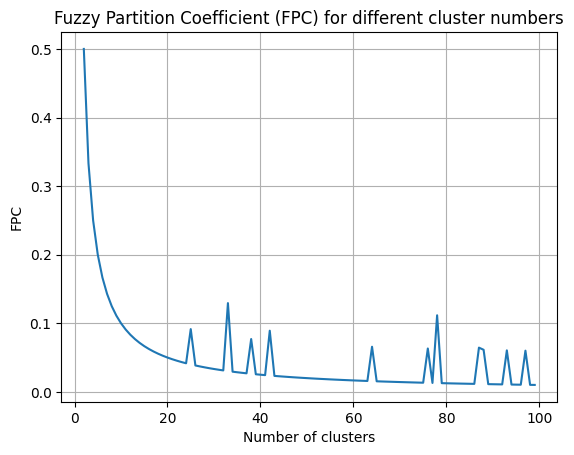

Optimal number of clusters: 12


In [8]:
optimal_clusters = determine_optimal_clusters(dissimilarity_matrix)
print(f"Optimal number of clusters: {optimal_clusters}")

In [9]:
memberships = fuzzy_cmeans_clustering(dissimilarity_matrix, nodes_list, optimal_clusters)
normalized_memberships = normalize_memberships(memberships)
fuzzy_memberships = assign_clusters_based_on_comparative_ratios(normalized_memberships)

for node, memberships in fuzzy_memberships.items():
        print(f"{node}: {', '.join(f'{cluster} ({membership:.2f})' for cluster, membership in memberships)}")

save_microservices_to_txt(fuzzy_memberships, communities_df, 
                           f"generated_data/phase3_microservice_clustering/cmeans/{version}_{system}_{best_community_detection_algorithm}_microservices.txt")
save_microservices_to_csv(fuzzy_memberships, communities_df, 
                           f"generated_data/phase3_microservice_clustering/cmeans/{version}_{system}_{best_community_detection_algorithm}_microservices.csv")

Application Service 1: cluster4 (0.09)
Application Service 2: cluster12 (0.08), cluster8 (0.08), cluster1 (0.08), cluster7 (0.08), cluster6 (0.08), cluster11 (0.08), cluster10 (0.08), cluster9 (0.08), cluster3 (0.08), cluster5 (0.08), cluster2 (0.08), cluster4 (0.08)
Application Service 3: cluster3 (0.08), cluster6 (0.08), cluster1 (0.08), cluster8 (0.08), cluster5 (0.08), cluster7 (0.08), cluster11 (0.08), cluster10 (0.08), cluster12 (0.08), cluster2 (0.08), cluster9 (0.08), cluster4 (0.08)
Application Service 4: cluster7 (0.08), cluster1 (0.08), cluster12 (0.08), cluster8 (0.08), cluster6 (0.08), cluster10 (0.08), cluster3 (0.08), cluster5 (0.08), cluster11 (0.08), cluster9 (0.08), cluster2 (0.08), cluster4 (0.08)
Application Service 5: cluster4 (0.09)
Application Service 6: cluster2 (0.09)
Application Service 7: cluster7 (0.08), cluster12 (0.08), cluster1 (0.08), cluster8 (0.08), cluster11 (0.08), cluster10 (0.08), cluster6 (0.08), cluster9 (0.08), cluster3 (0.08), cluster5 (0.08), 

### 1.2.1 Custom fuzzy C-means

In [10]:
class CustomFuzzyCMeans:
    """
    A custom implementation of the Fuzzy C-Means clustering algorithm.

    Attributes:
        center_type_indices: A dict mapping the service type to its index.
    """
    def __init__(self):
        self.center_type = 'Application'
        self.center_type_indices = {}

    def calculate_membership(self, service_idx, center_idx, distances):
        """
        Calculate the fuzzy membership of a service to a cluster center.
        
        Parameters:
        service_idx (int): Index of the service for which membership is being calculated.
        center_idx (int): Index of the cluster center to which membership is being calculated.
        distances (list): Matrix of distances between services and cluster centers.
        
        Returns:
        float: The membership value of the service to the cluster center.
        """
        epsilon = 1e-10  # Small value to avoid division by zero.
        distance_to_center = distances[service_idx][center_idx]

        membership_sum = 0.0

        if distance_to_center == 0:
            return 1.0
        
        for other_center_idx in self.center_type_indices.values():
            if other_center_idx != service_idx:
                # Direct distances to other centers
                other_distance_to_center = distances[service_idx][other_center_idx]

                membership_ratio = distance_to_center / (other_distance_to_center + epsilon)
                membership_sum += membership_ratio ** 2

        # The membership value is the inverse of the sum, normalized by the number of centers
        return 1 / membership_sum if membership_sum > 0 else 0

        
    def cluster_services(self, services_list, distances):
        """
        Cluster services based on their membership values to each cluster center.

        Parameters:
        services_list (list): List of all services to be clustered.
        distances (list): Matrix of distances between services and cluster centers.

        Returns:
        dict: A dictionary with services as keys and lists of (cluster, membership) tuples as values.
        """

        self.center_type_indices = {
            service: idx for idx, service in enumerate(nodes_list) if service.startswith(self.center_type)
        }
        
        # Calculate raw membership values for each service to each cluster center
        memberships = {}
        for service_idx, service in enumerate(services_list):
            service_memberships = []
            for idx, (_, center_idx) in enumerate(self.center_type_indices.items()):
                membership_value = self.calculate_membership(service_idx, center_idx, distances)
                service_memberships.append((f"cluster{idx+1}", membership_value))
            memberships[service] = service_memberships

        return memberships

In [11]:
memberships = CustomFuzzyCMeans().cluster_services(nodes_list, dissimilarity_matrix)
normalized_memberships = normalize_memberships(memberships)
fuzzy_memberships = assign_clusters_based_on_comparative_ratios(normalized_memberships)

# Call the method to merge clusters with overlap above merge_threshold
fuzzy_memberships = identify_standalone_services(fuzzy_memberships)
fuzzy_memberships = merge_overlapping_clusters(fuzzy_memberships, overlap_threshold=0.3)

for node, memberships in fuzzy_memberships.items():
        print(f"{node}: {', '.join(f'{cluster} ({membership:.2f})' for cluster, membership in memberships)}")
        
save_microservices_to_txt(fuzzy_memberships, communities_df, 
                           f"generated_data/phase3_microservice_clustering/custom_cmeans/{version}_{system}_{best_community_detection_algorithm}_microservices.txt")
save_microservices_to_csv(fuzzy_memberships, communities_df, 
                           f"generated_data/phase3_microservice_clustering/custom_cmeans/{version}_{system}_{best_community_detection_algorithm}_microservices.csv")

Standalone candidates: set()
Overlapping clusters: {(1, 5)}
Application Service 1: cluster1 (0.50)
Application Service 2: cluster2 (0.50)
Application Service 3: cluster3 (0.50)
Application Service 4: cluster4 (0.50)
Application Service 5: cluster1 (0.50)
Application Service 6: cluster5 (0.50)
Application Service 7: cluster6 (0.50)
Application Service 8: cluster7 (0.50)
Application Service 9: cluster8 (0.50)
Entity Service 1: cluster4 (0.50)
Entity Service 10: cluster1 (0.14)
Entity Service 2: cluster2 (0.62)
Entity Service 3: cluster1 (1.00)
Entity Service 4: cluster6 (0.47)
Entity Service 5: cluster3 (0.99)
Entity Service 6: cluster1 (0.13), cluster5 (0.12), cluster8 (0.12)
Entity Service 7: cluster1 (0.12), cluster7 (0.12)
Entity Service 8: cluster5 (0.74), cluster7 (0.07)
Entity Service 9: cluster1 (0.43)
Utility Service 1: cluster1 (0.11), cluster2 (0.11), cluster3 (0.11)


### 1.2.2 Hierarchical clustering

In [12]:
def perform_clustering(dissimilarity_matrix, max_d):
    Z = linkage(squareform(dissimilarity_matrix), method='average')
    clusters = fcluster(Z, max_d, criterion='distance')
    return clusters

def calculate_wcss(clusters, dissimilarity_matrix):
    wcss = 0
    for i in np.unique(clusters):
        cluster_points = dissimilarity_matrix[clusters == i]
        centroid = np.mean(cluster_points, axis=0)
        wcss += np.sum((cluster_points - centroid) ** 2)
    return wcss

def hierarchical_clustering(dissimilarity_matrix, nodes, max_d):
    """
    Perform hierarchical clustering and return fuzzy memberships.

    Parameters:
    - dissimilarity_matrix: The matrix of dissimilarity between nodes.
    - nodes: The list of node labels.
    - max_d: The threshold to cut the dendrogram to form clusters.

    Returns:
    - A dictionary with node labels as keys and a list of (cluster, membership) tuples as values.
    """
    # Perform the hierarchical clustering
    clusters = perform_clustering(dissimilarity_matrix, max_d)

    # Calculate the centroids of each cluster
    centroids = {i: np.mean(dissimilarity_matrix[clusters == i], axis=0) for i in np.unique(clusters)}

    # Initialize the fuzzy memberships dictionary
    memberships = {}

    for node_idx, node in enumerate(nodes):
        # Calculate distances to centroids
        distances = {f'cluster{i}': np.linalg.norm(centroids[i] - dissimilarity_matrix[node_idx]) for i in centroids}
        
        # Invert the distances to get membership strengths (higher distance -> lower membership)
        inverted_memberships = {cluster_label: 1 / (distance + 1e-5) for cluster_label, distance in distances.items()}
        
        # Add the inverted memberships to the raw_memberships dictionary for the node
        memberships[node] = list(inverted_memberships.items())
    
    return memberships

Optimal max_d is: 0.9


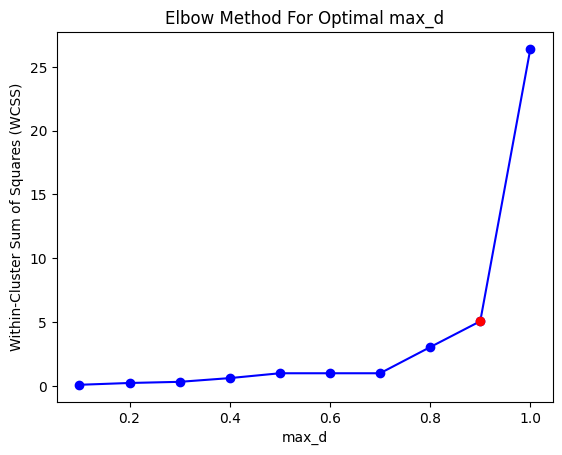

In [13]:
# Detecting the elbow
wcss_list = []
max_d_values = np.linspace(0.1, 1.0, 10)  # Adjust the range and step as needed

for max_d in max_d_values:
    clusters = perform_clustering(dissimilarity_matrix, max_d)
    wcss = calculate_wcss(clusters, dissimilarity_matrix)
    wcss_list.append(wcss)

elbow_index = detect_elbow(wcss_list)
optimal_max_d = max_d_values[elbow_index]

print(f"Optimal max_d is: {optimal_max_d}")

# Plotting the results with the elbow point highlighted
plt.plot(max_d_values, wcss_list, 'bo-')
plt.plot(max_d_values[elbow_index], wcss_list[elbow_index], 'ro')
plt.title('Elbow Method For Optimal max_d')
plt.xlabel('max_d')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

In [14]:
memberships = hierarchical_clustering(dissimilarity_matrix, nodes_list, max_d=optimal_max_d)

# Normalize the inverted memberships
normalized_memberships = normalize_memberships(memberships)
    
# Assign services to clusters based on peaks in their membership distributions
fuzzy_memberships = assign_clusters_based_on_comparative_ratios(normalized_memberships)

for node, memberships in fuzzy_memberships.items():
        print(f"{node}: {', '.join(f'{cluster} ({membership:.2f})' for cluster, membership in memberships)}")

save_microservices_to_txt(fuzzy_memberships, communities_df, 
                           f"generated_data/phase3_microservice_clustering/hierarchical/{version}_{system}_{best_community_detection_algorithm}_microservices.txt")

save_microservices_to_csv(fuzzy_memberships, communities_df, 
                           f"generated_data/phase3_microservice_clustering/hierarchical/{version}_{system}_{best_community_detection_algorithm}_microservices.csv")


Application Service 1: cluster4 (0.22)
Application Service 2: cluster1 (0.46)
Application Service 3: cluster8 (0.65)
Application Service 4: cluster3 (0.40)
Application Service 5: cluster4 (0.26)
Application Service 6: cluster9 (0.23)
Application Service 7: cluster2 (0.39)
Application Service 8: cluster9 (0.16)
Application Service 9: cluster5 (1.00)
Entity Service 1: cluster3 (0.40)
Entity Service 10: cluster7 (1.00)
Entity Service 2: cluster1 (0.46)
Entity Service 3: cluster4 (0.20)
Entity Service 4: cluster2 (0.39)
Entity Service 5: cluster8 (0.65)
Entity Service 6: cluster6 (1.00)
Entity Service 7: cluster10 (0.20)
Entity Service 8: cluster9 (0.34)
Entity Service 9: cluster4 (0.14)
Utility Service 1: cluster10 (0.20)


# 1.3 Compute Result measure for all models

In [42]:
models = ['custom_cmeans', 'cmeans', 'hierarchical']
ground_truth_path = f"ground_truths/{version}/{system}/microservices/microservices.csv"
import csv
def read_csv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        return [row for row in reader]

def match_services(ground_truth, result, matching_threshold):
    # Convert ground truth and result to sets for easy comparison
    ground_truth_set = set(ground_truth)
    result_set = set(result)

    # Count the number of services in the ground truth
    total_services = len(ground_truth_set)

    # Calculate the intersection size
    intersection_size = len(ground_truth_set.intersection(result_set))

    # Check if the result is considered a match based on the threshold
    return intersection_size / total_services >= matching_threshold

# find_best_match returns the greatest ratio of the matching between the microservice genrated and the ground truths
# For example, a ratio of 0.5 means that half of the services in the result set of a microservice are found in the ground truths that best matches
def find_best_match(microservice_result, microservices_ground_truths):
    max_intersection_ratio = max(
        len(set(microservice_ground_truth).intersection(set(microservice_result))) / len(set(microservice_ground_truth))
        for microservice_ground_truth in microservices_ground_truths
    )
    return max_intersection_ratio

        

def calculate_microservices_clustering_results(ground_truth_path, results_path, matching_threshold):
    microservices_ground_truths = read_csv(ground_truth_path)
    microservices_results = read_csv(results_path)

    # Initialize True Positives (TP)
    tp = 0

    # Iterate over results to check for True Positives
    for i, microservice_result in enumerate(microservices_results):
        best_match_ratio = find_best_match(microservice_result, microservices_ground_truths)
        print(f"Microservice {i}, best match ratio = {best_match_ratio}")
        if best_match_ratio > matching_threshold:
            tp += 1
    # Calculate False Positives (FP) and False Negatives (FN)
    fp = len(microservices_results) - tp
    fn = len(microservices_ground_truths) - tp

    # Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # Calculate F-measure
    f_measure = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f_measure, tp, fp, fn

for m in models:
    print(f"Results for model: {m}")
    results_path = f"generated_data/phase3_microservice_clustering/{m}/{version}_{system}_{best_community_detection_algorithm}_microservices.csv"
    precision, recall, f_measure, tp, fp, fn= calculate_microservices_clustering_results(ground_truth_path, results_path, 0.8)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F-measure: {f_measure}")
    print(f"TP: {tp}")
    print(f"FP: {fp}")
    print(f"FN: {fn}")
    
    print("--------------------------")

Results for model: custom_cmeans
Microservice 0, best match ratio = 0.5
Microservice 1, best match ratio = 0.5555555555555556
Microservice 2, best match ratio = 0.5555555555555556
Microservice 3, best match ratio = 0.5555555555555556
Microservice 4, best match ratio = 0.25
Microservice 5, best match ratio = 0.2857142857142857
Microservice 6, best match ratio = 0.2857142857142857
Microservice 7, best match ratio = 0.125
Precision: 0.0
Recall: 0.0
F-measure: 0.0
TP: 0
FP: 8
FN: 11
--------------------------
Results for model: cmeans
Microservice 0, best match ratio = 0.5
Microservice 1, best match ratio = 0.5
Microservice 2, best match ratio = 0.5
Microservice 3, best match ratio = 0.5555555555555556
Microservice 4, best match ratio = 0.5
Microservice 5, best match ratio = 0.5
Microservice 6, best match ratio = 0.5
Microservice 7, best match ratio = 0.5
Microservice 8, best match ratio = 0.5
Microservice 9, best match ratio = 0.5
Microservice 10, best match ratio = 0.5
Microservice 11, b